In [19]:
from __future__ import division
%pylab  inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Monte Carlo Sampling Methods

So far, we have studied analytical ways to transform random variables and how
to augment these methods using Python. In spite of all this, we frequently must
resort to purely numerical methods to solve real-world problems.  Hopefully,
now that we have seen the deeper theory, these numerical methods feel more
concrete.  Suppose we want to generate samples of a given density, $f(x)$,
given we already can generate samples from a uniform distribution,
$\mathcal{U}[0,1]$.  How do we know a random sample $v$ comes from the $f(x)$
distribution?  One approach is to look at how a histogram of samples of $v$
approximates $f(x)$. Specifically,

<!-- Equation labels as ordinary links -->
<div id="eq:mc01"></div>

$$
\begin{equation}
\mathbb{P}( v \in N_{\Delta}(x) )  = f(x) \Delta x 
\end{equation}
\label{eq:mc01} \tag{1}
$$

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_000.png, width=500 frac=0.75] The histogram approximates the target probability density. <div id="fig:Sampling_Monte_Carlo_000"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_000"></div>

<p>The histogram approximates the target probability density.</p>
<img src="fig-probability/Sampling_Monte_Carlo_000.png" width=500>

<!-- end figure -->


 which says that the probability that a sample is in some $N_\Delta$
neighborhood of $x$ is approximately $f(x)\Delta x$. [Figure](#fig:Sampling_Monte_Carlo_000) shows the target probability density function
$f(x)$ and a histogram that approximates it. The histogram is generated from
samples $v$. The hatched rectangle in the center illustrates Equation
ref{eq:mc01}. The area of this rectangle is approximately $f(x)\Delta x$ where
$x=0$, in this case. The width of the rectangle is $N_{\Delta}(x)$ The quality
of the approximation may be clear visually, but to know that $v$ samples are
characterized by $f(x)$, we need the statement of Equation ref{eq:mc01}, which
says that the proportion of samples $v$  that fill the hatched rectangle is
approximately equal to $f(x)\Delta x$.

Now that we know how to evaluate samples $v$ that are characterized by the density
$f(x)$, let's consider how to create these samples for both discrete and
continuous random variables.

## Inverse CDF Method for Discrete Variables

Suppose we want to generate samples from a fair six-sided die.  Our workhouse
uniform random variable is defined continuously over the unit interval  and the
fair six-sided die is discrete. We must first create a mapping between the
continuous random variable $u$ and the discrete outcomes of the die. This
mapping is shown in [Figure](#fig:Sampling_Monte_Carlo_0001) where the unit
interval is broken up into segments, each of length $1/6$. Each individual
segment is assigned to one of the die outcomes. For example, if $u \in
[1/6,2/6)$, then the outcome for the die is $2$. Because the die is fair, all
segments on the unit interval are the same length. Thus, our new random
variable $v$ is derived from $u$ by this assignment.

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_0001.png, width=500 frac=0.75] A uniform distribution random variable on the unit interval is assigned to the six outcomes of a fair die using these segements. <div id="fig:Sampling_Monte_Carlo_0001"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_0001"></div>

<p>A uniform distribution random variable on the unit interval is assigned to the six outcomes of a fair die using these segements.</p>
<img src="fig-probability/Sampling_Monte_Carlo_0001.png" width=500>

<!-- end figure -->


For example, for $v=2$, we have,

$$
\mathbb{P}(v=2) = \mathbb{P}(u\in [1/6,2/6)) = 1/6
$$

 where, in the language of the Equation ref{eq:mc01}, $f(x)=1$
(uniform distribution), $\Delta x = 1/6$, and $N_\Delta (2)=[1/6,2/6)$.
Naturally, this pattern holds for all the other die outcomes in
$\left\{1,2,3,..,6\right\}$.  Let's consider a quick simulation to make this
concrete. The following code generates uniform random samples and stacks them
in a Pandas dataframe.

In [20]:
import pandas as pd
import numpy as np
from pandas import DataFrame
u= np.random.rand(100)
df = DataFrame(data=u,columns=['u'])

 The next block uses `pd.cut` to map the individual samples to
the set $\left\{1,2,\ldots,6\right\}$ labeled `v`.

In [21]:
labels = [1,2,3,4,5,6]
df['v']=pd.cut(df.u,np.linspace(0,1,7),
               include_lowest=True,labels=labels)

 This is what the dataframe contains. The `v` column contains
the samples drawn from the fair die.

In [22]:
>>> df.head()
          

,u,v
0,0.822279,5
1,0.294439,2
2,0.416778,3
3,0.500384,4
4,0.070402,1


 The following is a count of the number of samples in each group. There
should be roughly the same number of samples in each group because the die is fair.

In [23]:
>>> df.groupby('v').count()
    

,u
v,
1,10
2,30
3,15
4,11
5,16
6,18


 So far, so good. We now have a way to simulate a fair
die from a uniformly distributed random variable.

To extend this to unfair die, we need only make some small adjustments to this
code.  For example, suppose that we want an unfair die so that
$\mathbb{P}(1)=\mathbb{P}(2)=\mathbb{P}(3)=1/12$ and
$\mathbb{P}(4)=\mathbb{P}(5)=\mathbb{P}(6)=1/4$. The only change we have to
make is with `pd.cut` as follows,

In [24]:
df['v']=pd.cut(df.u,[0,1/12,2/12,3/12,2/4,3/4,1],
               include_lowest=True,labels=labels)

In [25]:
>>> df.groupby('v').count()/df.shape[0]
      

,u
v,
1,0.06
2,0.04
3,0.16
4,0.29
5,0.17
6,0.28


 where now these are the individual probabilities of each digit. You
can take more than `100` samples to get a clearer view of the individual
probabilities but the mechanism for generating them is the same. The method is
called the inverse CDF [^CDF] method because the CDF
(namely,$\texttt{[0,1/12,2/12,3/12,2/4,3/4,1]}$) in the last example has been
inverted (using the `pd.cut` method) to generate the samples.  
The inversion is easier to see for continuous variables, which we consider
next.

[^CDF]: Cumulative density function. Namely, $F(x)=\mathbb{P}(X < x)$.


## Inverse CDF Method for Continuous Variables

The method above applies to continuous random variables, but now we have to use
squeeze the  intervals down to individual points. In the example above, our
inverse function was a piecewise function that operated on uniform random
samples. In this case, the piecewise function collapses to a continuous inverse
function.  We want to generate random samples for a CDF that is invertible.
As before, the criterion for generating an appropriate sample $v$ is the
following,

$$
\mathbb{P}(F(x) < v < F(x+\Delta x)) =  F(x+\Delta x) - F(x) = \int_x^{x+\Delta x} f(u) du \approx  f(x) \Delta x
$$

 which is saying that the probability that the sample $v$ is contained
in a $\Delta x$ interval is approximately equal to the density function, $f(x)
\Delta x$, at that point. Once again, the trick is to use a uniform random
sample $u$ and an invertible CDF $F(x)$ to construct these samples.  Note
that for a uniform random variable $u \sim \mathcal{U}[0,1]$, we have,

$$
\begin{align*}
\mathbb{P}(x < F^{-1}(u) < x+\Delta x) & = \mathbb{P}(F(x) < u < F(x+\Delta x)) \\\
                                       & =  F(x+\Delta x) - F(x) \\\
                                       & = \int_x^{x+\Delta x} f(p) dp \approx  f(x) \Delta x
\end{align*}
$$

 This means that $ v=F^{-1}(u) $ is distributed according to $f(x)$,
which is what we want.  

Let's try this to generate samples from the
exponential distribution,

$$
f_{\alpha}(x) = \alpha e^{ -\alpha x }
$$

 which has the following CDF,

$$
F(x) = 1-e^{ -\alpha x  }
$$

 and corresponding inverse,

$$
F^{-1}(u)  = \frac{1}{\alpha}\ln \frac{1}{(1-u)}
$$

 Now, all we have to do is generate some uniformly distributed
random samples and then feed them into $F^{-1}$.

In [26]:
from numpy import array, log
import scipy.stats
alpha = 1.   # distribution parameter
nsamp = 1000 # num of samples
# define uniform random variable
u=scipy.stats.uniform(0,1)
# define inverse function
Finv=lambda u: 1/alpha*log(1/(1-u))
# apply inverse function to samples
v = array(map(Finv,u.rvs(nsamp)))

 Now, we have the samples from the exponential distribution, but how
do we know the method is correct with samples distributed accordingly?
Fortunately, `scipy.stats` already has a exponential distribution, so we can
check our work against the reference using a *probability plot* (i.e.,  also
known as a *quantile-quantile* plot).  The following code sets up the
probability plot from `scipy.stats`.

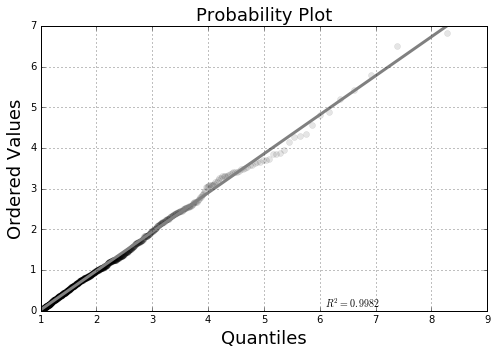

In [27]:
%matplotlib inline

from matplotlib.pylab import setp, subplots
fig,ax = subplots()
fig.set_size_inches((7,5))
_=scipy.stats.probplot(v,(1,),dist='expon',plot=ax)
line=ax.get_lines()[0]
_=setp(line,'color','k')
_=setp(line,'alpha',.1)
line=ax.get_lines()[1]
_=setp(line,'color','gray')
_=setp(line,'lw',3.0)
_=setp(ax.yaxis.get_label(),'fontsize',18)
_=setp(ax.xaxis.get_label(),'fontsize',18)
_=ax.set_title('Probability Plot',fontsize=18)
_=ax.grid()
fig.tight_layout()
#fig.savefig('fig-probability/Sampling_Monte_Carlo_005.png')

((array([ 1.00069315,  1.0016833 ,  1.00268512,  1.00368795,  1.00469178,
          1.00569662,  1.00670247,  1.00770934,  1.00871722,  1.00972611,
          1.01073603,  1.01174696,  1.01275892,  1.01377191,  1.01478592,
          1.01580096,  1.01681703,  1.01783414,  1.01885228,  1.01987145,
          1.02089167,  1.02191293,  1.02293524,  1.02395859,  1.02498299,
          1.02600844,  1.02703494,  1.02806249,  1.02909111,  1.03012078,
          1.03115151,  1.03218331,  1.03321617,  1.03425011,  1.03528511,
          1.03632118,  1.03735833,  1.03839655,  1.03943586,  1.04047624,
          1.04151771,  1.04256027,  1.04360391,  1.04464864,  1.04569447,
          1.04674139,  1.04778941,  1.04883852,  1.04988874,  1.05094006,
          1.05199249,  1.05304603,  1.05410068,  1.05515644,  1.05621332,
          1.05727132,  1.05833044,  1.05939068,  1.06045204,  1.06151454,
          1.06257816,  1.06364292,  1.06470881,  1.06577583,  1.066844  ,
          1.06791331,  1.06898377,  1.

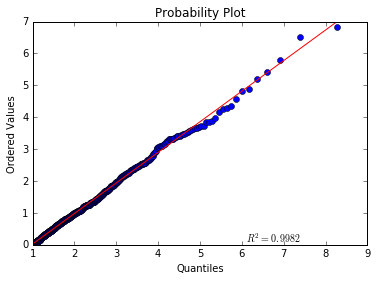

In [28]:
fig,ax=subplots()
scipy.stats.probplot(v,(1,),dist='expon',plot=ax)

 Note that we have to supply an axes object (`ax`) for it to draw on.
The result is [Figure](#fig:Sampling_Monte_Carlo_005). The more the samples
line match the diagonal line, the more they match the reference distribution
(i.e., exponential distribution in this case). You may also want to try
`dist=norm` in the code above To see what happens when the normal distribution
is the reference distribution.

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_005.png, width=500 frac=0.85] The samples created using the inverse cdf method match the exponential reference distribution. <div id="fig:Sampling_Monte_Carlo_005"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_005"></div>

<p>The samples created using the inverse cdf method match the exponential reference distribution.</p>
<img src="fig-probability/Sampling_Monte_Carlo_005.png" width=500>

<!-- end figure -->


## Rejection Method

In some cases, inverting the CDF may be impossible. The *rejection*
method can handle this situation. The idea is to pick two uniform random
variables $u_1,u_2 \sim \mathcal{U}[a,b]$ so that

$$
\mathbb{P}\left(u_1 \in N_{\Delta}(x) \bigwedge u_2 < \frac{f(u_1)}{M} \right) \hspace{0.5em} \approx \frac{\Delta x}{b-a} \frac{f(u_1)}{M}
$$

 where we take $x=u_1$ and $f(x) < M $.  This is a two-step process.
First, draw $u_1$ uniformly from the interval $[a,b]$. Second,  feed it into
$f(x)$ and if $u_2 < f(u_1)/M$, then you have a valid sample for $f(x)$. Thus,
$u_1$ is the proposed sample from $f$ that may or may not be rejected depending
on $u_2$. The only job of the $M$ constant is to scale down the $f(x)$ so that
the $u_2$ variable can span the range.  The *efficiency* of this method is the
probability of accepting $u_1$ which comes from integrating out the above
approximation,

$$
\int \frac{f(x)}{M(b-a)} dx = \frac{1}{M(b-a)} \int f(x)dx =\frac{1}{M(b-a)}
$$

 This means that we don't want an unecessarily large $M$ because that
makes it more likely that samples will be discarded. 

Let's try this method for a density that does not have a continuous inverse [^normalization]. 

[^normalization]: Note that this example density does not *exactly* integrate
out to one like a probability density function should, but the normalization
constant for this is distracting for our purposes here.

$$
f(x) = \exp\left(-\frac{(x-1)^2}{2x} \right) (x+1)/12
$$

 where $x>0$. The following code implements the rejection plan.

In [29]:
import numpy as np
x = np.linspace(0.001,15,100)
f= lambda x: np.exp(-(x-1)**2/2./x)*(x+1)/12.
fx = f(x)
M=0.3                          # scale factor
u1 = np.random.rand(10000)*15  # uniform random samples scaled out
u2 = np.random.rand(10000)     # uniform random samples
idx,= np.where(u2<=f(u1)/M)    # rejection criterion
v = u1[idx]

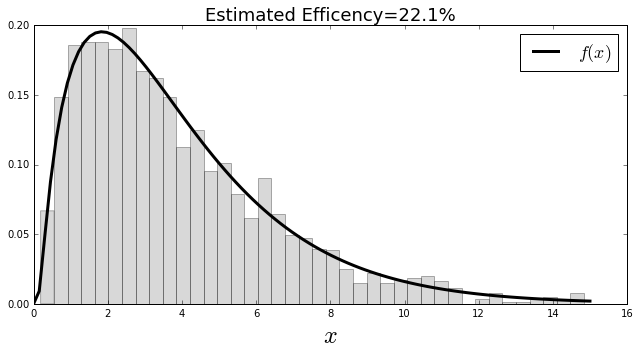

In [30]:
fig,ax=subplots()
fig.set_size_inches((9,5))
_=ax.hist(v,normed=1,bins=40,alpha=.3,color='gray')
_=ax.plot(x,fx,'k',lw=3.,label='$f(x)$')
_=ax.set_title('Estimated Efficency=%3.1f%%'%(100*len(v)/len(u1)),
             fontsize=18)
_=ax.legend(fontsize=18)
_=ax.set_xlabel('$x$',fontsize=24)
fig.tight_layout()
#fig.savefig('fig-probability/Sampling_Monte_Carlo_007.png')

 [Figure](#fig:Sampling_Monte_Carlo_007) shows a histogram of the
so-generated samples that nicely fits the probability density function. The
title in the figure shows the efficiency, which is poor. It means that we threw
away most of the proposed samples.  Thus, even though there is nothing
conceptually wrong with this result, the low efficiency must be fixed, as a
practical matter.  [Figure](#fig:Sampling_Monte_Carlo_008) shows where the
proposed samples were rejected. Samples under the curve were retained (i.e.,
$u_2 < \frac{f(u_1)}{M}$) but the vast majority of the samples are outside this
umbrella.

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_007.png, width=500 frac=0.75] The rejection method generate samples in the histogram that nicely match the target distribution. Unfortunately, the efficiency is not so good. <div id="fig:Sampling_Monte_Carlo_007"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_007"></div>

<p>The rejection method generate samples in the histogram that nicely match the target distribution. Unfortunately, the efficiency is not so good.</p>
<img src="fig-probability/Sampling_Monte_Carlo_007.png" width=500>

<!-- end figure -->

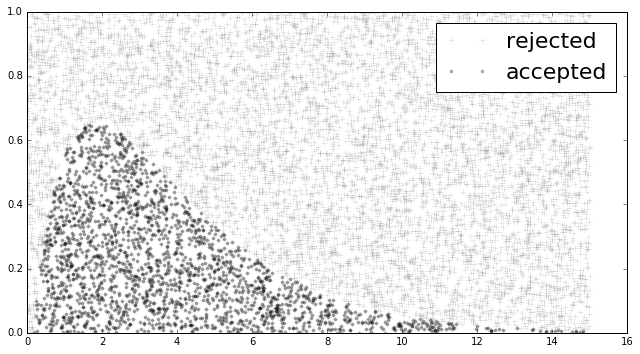

In [31]:
fig,ax=subplots()
fig.set_size_inches((9,5))
_=ax.plot(u1,u2,'+',label='rejected',alpha=.3,color='gray')
_=ax.plot(u1[idx],u2[idx],'.',label='accepted',alpha=.3,color='k')
_=ax.legend(fontsize=22)
fig.tight_layout()
#fig.savefig('fig-probability/Sampling_Monte_Carlo_008.png')

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_008.png, width=500 frac=0.75] The proposed samples under the curve were accepted and the others were not. This shows the majority of samples were rejected.  <div id="fig:Sampling_Monte_Carlo_008"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_008"></div>

<p>The proposed samples under the curve were accepted and the others were not. This shows the majority of samples were rejected.</p>
<img src="fig-probability/Sampling_Monte_Carlo_008.png" width=500>

<!-- end figure -->


The rejection method uses $u_1$ to select along the domain of $f(x)$ and the
other $u_2$ uniform random variable  decides whether to accept or not. One idea
would be to choose $u_1$ so that $x$ values are coincidentally those that are
near the peak of $f(x)$, instead of uniformly anywhere in the domain,
especially near the tails, which are low probability anyway. Now, the trick is
to find a new density function $g(x)$ to sample from that has a similiar
concentration of probability density. One way it to familiarize oneself with
the probability density functions that have adjustable parameters and fast random
sample generators already. There are lots of places to look and, chances are,
there is likely already such a generator for your problem. Otherwise, the
family of $\beta$ densities is a good place to start. 

To be explicit, what we want is $u_1 \sim g(x)$ so that, returning to our
earlier argument,

$$
\mathbb{P}\left( u_1 \in N_{\Delta}(x) \bigwedge u_2 < \frac{f(u_1)}{M} \right) \approx g(x) \Delta x \frac{f(u_1)}{M}
$$

 but this is *not* what we need here. The problem is with the
second part of the logical $\bigwedge$ conjunction. We need to put
something there that will give us something proportional to $f(x)$.
Let us  define the following,

<!-- Equation labels as ordinary links -->
<div id="eq:rej01"></div>

$$
\begin{equation}
 h(x) = \frac{f(x)}{g(x)} 
\end{equation}
\label{eq:rej01} \tag{2}
$$

 with corresponding maximum on the domain as $h_{\max}$ and
then go back and construct the second part of the clause as

$$
\mathbb{P}\left(u_1 \in N_{\Delta}(x) \bigwedge u_2 < \frac{h(u_1)}{h_{\max}} \right) \approx g(x) \Delta x \frac{h(u_1)}{h_{\max}} = f(x)/h_{\max}
$$

 Recall that satisfying this criterion means that $u_1=x$. As before,
we can estimate the probability of acceptance of the $u_1$ as $1/h_{\max}$.

Now, how to construct the $g(x)$ function in the denominator of Equation
ref{eq:rej01}? Here's where familarity with some standard probability densities
pays off. For this case, we choose the chi-squared distribution. The following
plots the $g(x)$ and $f(x)$ (left plot) and the corresponding $h(x)=f(x)/g(x)$
(right plot). Note that $g(x)$ and $f(x)$ have peaks that almost coincide,
which is what we are looking for.

In [ ]:
ch=scipy.stats.chi2(4) # chi-squared
h = lambda x: f(x)/ch.pdf(x) # h-function

In [ ]:
fig,axs=subplots(1,2,sharex=True)
fig.set_size_inches(12,4)
_=axs[0].plot(x,fx,label='$f(x)$',color='k')
_=axs[0].plot(x,ch.pdf(x),'--',lw=2,label='$g(x)$',color='gray')
_=axs[0].legend(loc=0,fontsize=24)
_=axs[0].set_xlabel(r'$x$',fontsize=22)
_=axs[1].plot(x,h(x),'-k',lw=3)
_=axs[1].set_title('$h(x)=f(x)/g(x)$',fontsize=24)
_=axs[1].set_xlabel(r'$x$',fontsize=22)
fig.tight_layout()
#fig.savefig('fig-probability/Sampling_Monte_Carlo_009.png')

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_009.png, width=500 frac=0.95] The plot on the right shows $h(x)=f(x)/g(x)$ and the one on the left shows $f(x)$ and $g(x)$ separately. <div id="fig:Sampling_Monte_Carlo_009"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_009"></div>

<p>The plot on the right shows $h(x)=f(x)/g(x)$ and the one on the left shows $f(x)$ and $g(x)$ separately.</p>
<img src="fig-probability/Sampling_Monte_Carlo_009.png" width=500>

<!-- end figure -->


 Now, let's generate  some samples from this $\chi^2$
distribution with the rejection method.

In [ ]:
hmax=h(x).max()
u1 = ch.rvs(5000)        # samples from chi-square distribution
u2 = np.random.rand(5000)# uniform random samples
idx = (u2 <= h(u1)/hmax) # rejection criterion
v = u1[idx]              # keep these only

In [ ]:
fig,ax=subplots()
fig.set_size_inches((7,3))
_=ax.hist(v,normed=1,bins=40,alpha=.3,color='gray')
_=ax.plot(x,fx,color='k',lw=3.,label='$f(x)$')
_=ax.set_title('Estimated Efficency=%3.1f%%'%(100*len(v)/len(u1)))
_=ax.axis(xmax=15)
_=ax.legend(fontsize=18)
#fig.savefig('fig-probability/Sampling_Monte_Carlo_010.png')

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_010.png, width=500 frac=0.85]  Using the updated method, the histogram matches the target probability density function with high efficiency. <div id="fig:Sampling_Monte_Carlo_010"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_010"></div>

<p>Using the updated method, the histogram matches the target probability density function with high efficiency.</p>
<img src="fig-probability/Sampling_Monte_Carlo_010.png" width=500>

<!-- end figure -->


Using the $\chi^2$ distribution with the rejection method results in throwing
away less than 10% of the generated samples compared with our prior example
where we threw out at least 80%. This is dramatically more
efficient.  [Figure](#fig:Sampling_Monte_Carlo_010) shows that the histogram
and the probability density function match.  For completeness, [Figure](#fig:Sampling_Monte_Carlo_011) shows the samples with the corresponding
threshold $h(x)/h_{\max}$ that was used to select them.

In [ ]:
fig,ax=subplots()
fig.set_size_inches((7,4))
_=ax.plot(u1,u2,'+',label='rejected',alpha=.3,color='gray')
_=ax.plot(u1[idx],u2[idx],'g.',label='accepted',alpha=.3,color='k')
_=ax.plot(x,h(x)/hmax,color='k',lw=3.,label='$h(x)$')
_=ax.legend(fontsize=16,loc=0) 
_=ax.set_xlabel('$x$',fontsize=24)
_=ax.set_xlabel('$h(x)$',fontsize=24)
_=ax.axis(xmax=15,ymax=1.1)
fig.tight_layout()
#fig.savefig('fig-probability/Sampling_Monte_Carlo_011.png')

<!-- dom:FIGURE: [fig-probability/Sampling_Monte_Carlo_011.png, width=500 frac=0.95]  Fewer proposed points were rejected in this case, which means better efficiency. <div id="fig:Sampling_Monte_Carlo_011"></div> -->
<!-- begin figure -->
<div id="fig:Sampling_Monte_Carlo_011"></div>

<p>Fewer proposed points were rejected in this case, which means better efficiency.</p>
<img src="fig-probability/Sampling_Monte_Carlo_011.png" width=500>

<!-- end figure -->


In this section, we investigated how to generate random samples from a given
distribution, beit discrete or continuous. For the continuous case, the key
issue was whether or not the cumulative density function had a continuous
inverse. If not, we had to turn to the rejection method, and find an
appropriate related density that we could easily sample from to use as part of
a rejection threshold. Finding such a function is an art, but many families of
probability densities have been studied over the years that already have fast
random number generators.

The rejection method has many complicated extensions that involve careful
partitioning of the domains and lots of special methods for corner cases.
Nonetheless, all of these advanced techniques are still variations on the same
fundamental theme we illustrated here [[dunn2011exploring]](#dunn2011exploring),[[johnson1995continuous]](#johnson1995continuous).